In [3]:
import pandas as pd
import yaml
from sklearn.metrics import ConfusionMatrixDisplay
root_path = '/local/work/merengelke/aipal/'
config = yaml.load(open('cfg.yaml', 'r'), Loader=yaml.FullLoader)
# irgonre SettingWithCopyWarning
pd.options.mode.chained_assignment = None


cities_countries = config['cities_countries']
paths = [f"{root_path}{city_country}/aipal/predict.csv" for city_country in cities_countries]

df = pd.DataFrame()
for path in paths:
    df_small = pd.read_csv(path)
    df_small['city_country'] = path.split('/')[-3]
    df = pd.concat([df, df_small])
    
# age over 18
if config['is_adult']:
    df = df[df['age'] > 18]
else:
    df = df[df['age'] <= 18]
df.drop(columns=['ELN', 'Diagnosis', 'additional.diagnosis.details..lineage.etc', 'lineage.details'], inplace=True)


In [4]:
def prediction_data_pruner(df, threshold=0):
    """Remove data rows based on the threshold of missing values."""
    data = df
    mandatory_columns = ['Fibrinogen_g_L', 'LDH_UI_L', 'WBC_G_L', 'Lymphocytes_G_L',
    'MCHC_g_L', 'MCV_fL', 'Monocytes_G_L', 'Platelets_G_L',
    'PT_percent']
    
    ['MCV_fL', 'PT_percent', 'LDH_UI_L', 'MCHC_g_L', 'WBC_G_L', 'Fibrinogen_g_L', 'Monocytes_G_L', 'Platelets_G_L', 'Lymphocytes_G_L']

    data["nan_percentage"] = data[mandatory_columns].isna().mean(axis=1)

    # Prune data where the percentage of NaN values is above the threshold
    data = data[data["nan_percentage"] <= threshold]
    data.drop(columns=["nan_percentage"], inplace=True)
    return data


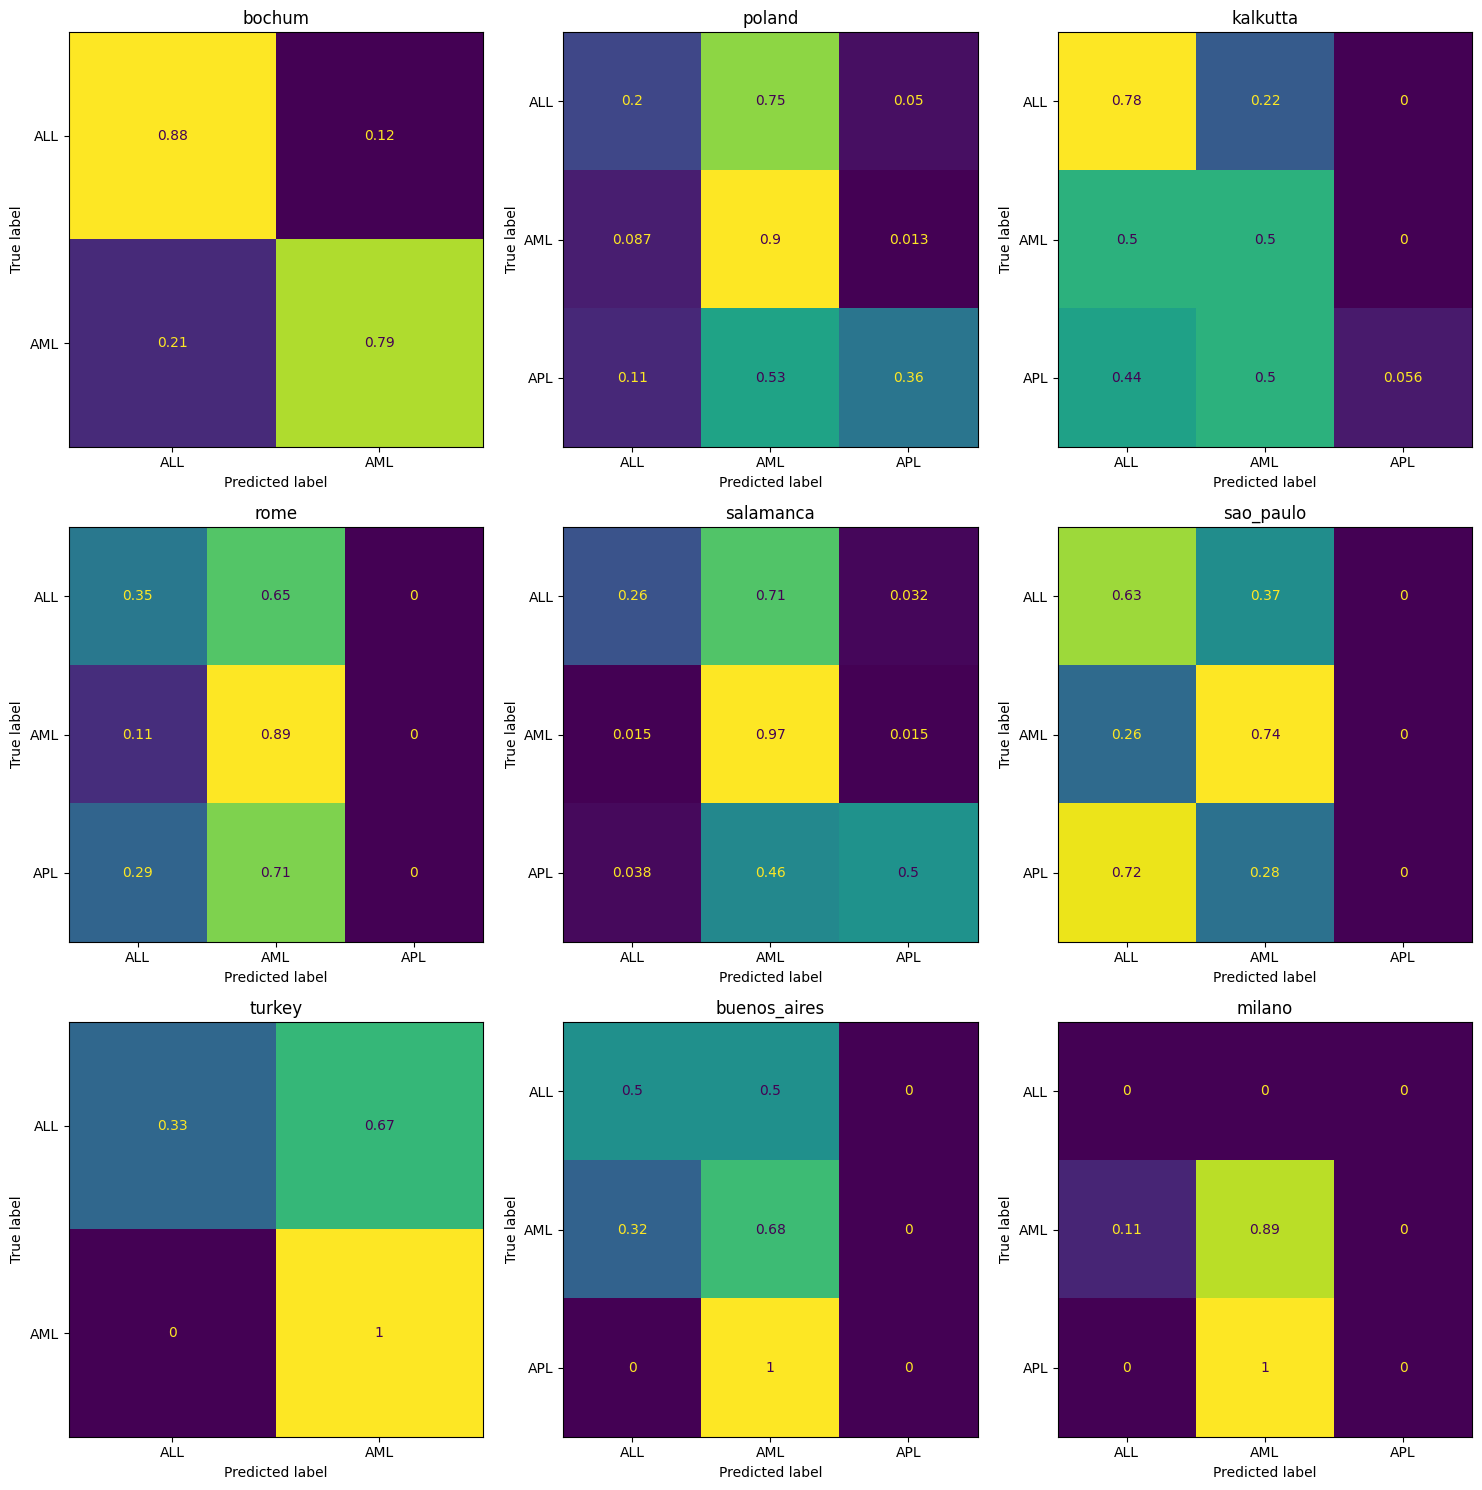

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def get_confusion_matrix(df, ax, title):
    adult_df = df[df['age'] >= 18].copy()
    adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]] = adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]].astype(float)

    # Assuming prediction_data_pruner is defined elsewhere
    adult_df = prediction_data_pruner(adult_df, threshold=0.2)

    adult_df["max_pred"] = adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]].idxmax(axis=1)
    adult_df["max_pred"] = adult_df["max_pred"].str.split(".").str[1]
    
    cm_display = ConfusionMatrixDisplay.from_predictions(adult_df["class"], adult_df["max_pred"], ax=ax, colorbar=False, normalize='true')
    ax.set_title(title)

# Create the figure with subplots
n_cities = df['city_country'].nunique()
n_rows = (n_cities + 2) // 3  # Calculate rows needed for 3 columns
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, city_country in enumerate(df['city_country'].unique()):
    df_small = df[df['city_country'] == city_country]
    get_confusion_matrix(df_small, axes[i], title=city_country)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

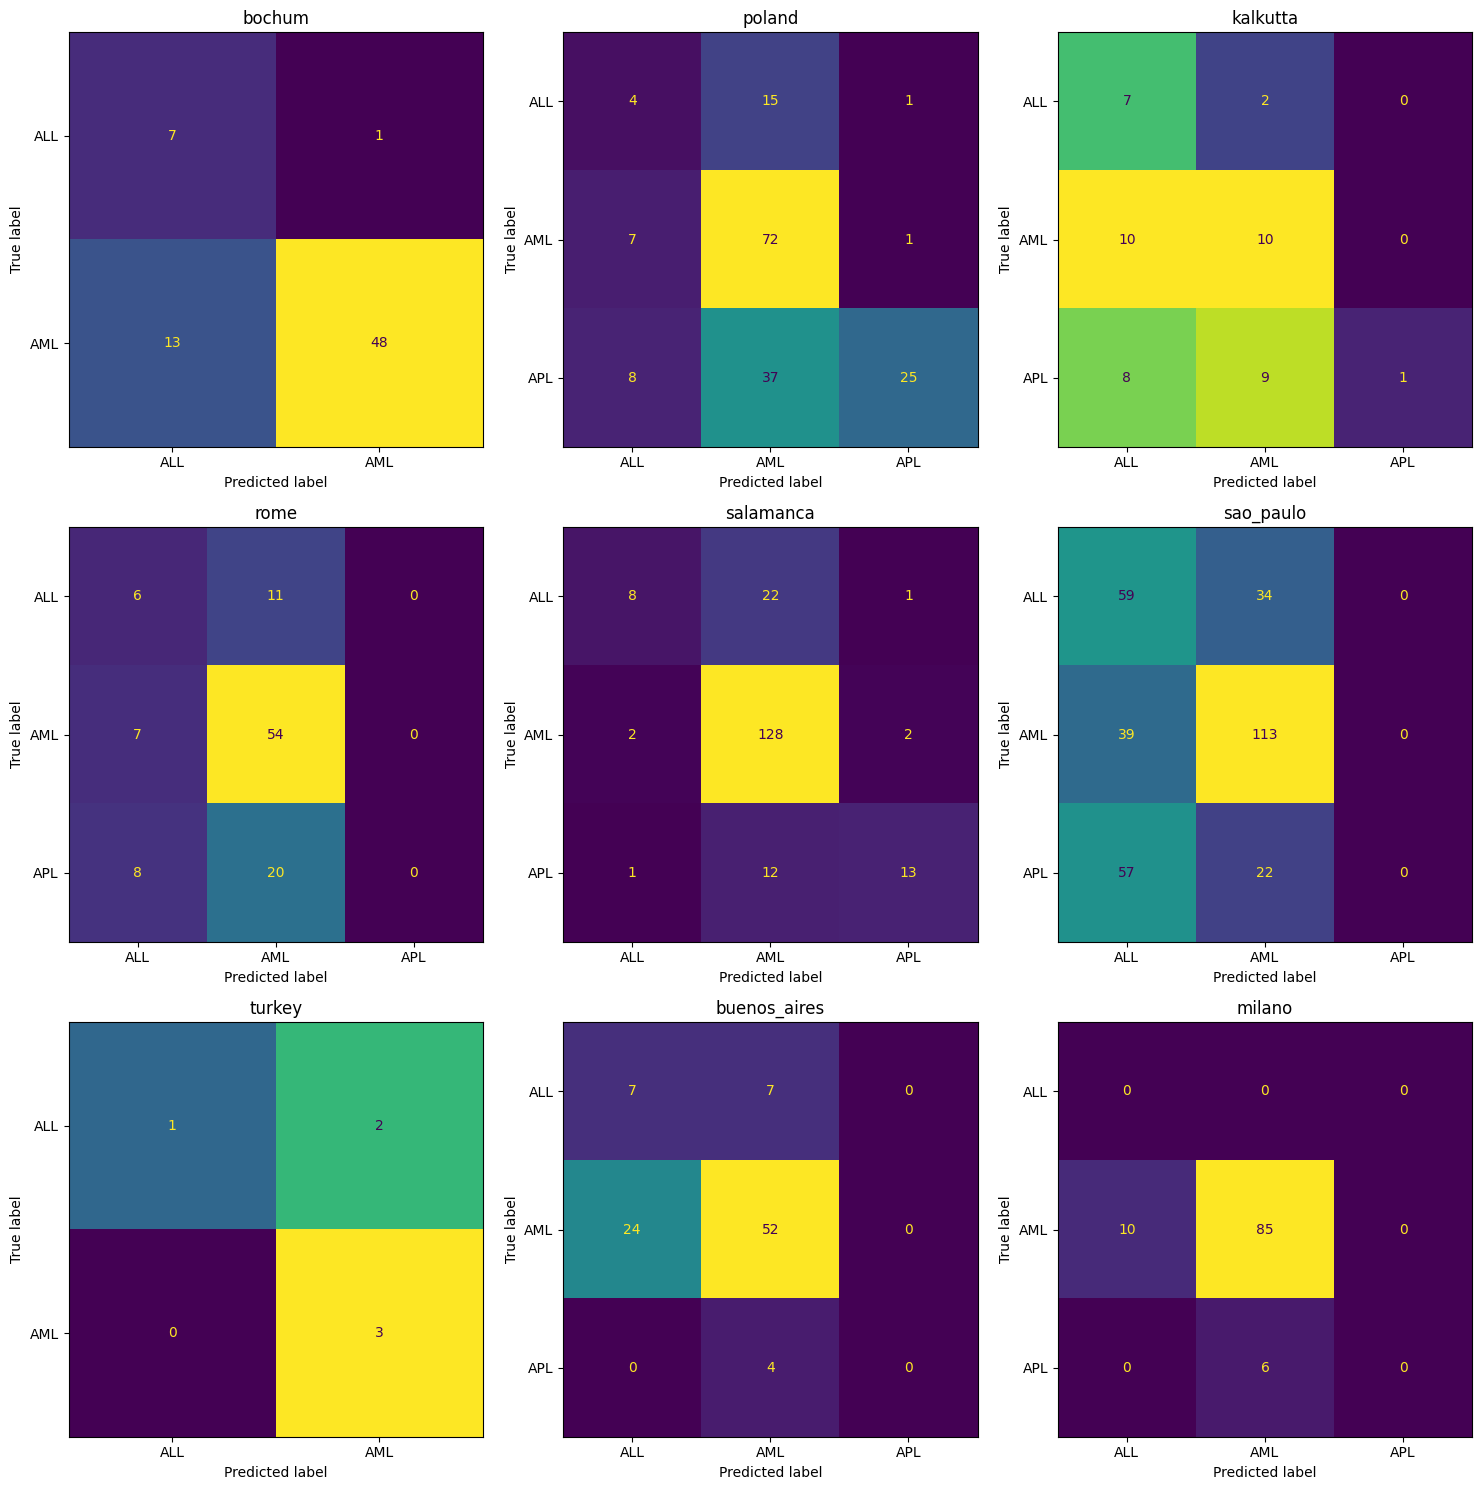

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def get_confusion_matrix(df, ax, title):
    adult_df = df[df['age'] >= 18].copy()
    adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]] = adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]].astype(float)

    # Assuming prediction_data_pruner is defined elsewhere
    adult_df = prediction_data_pruner(adult_df, threshold=0.2)

    adult_df["max_pred"] = adult_df[["prediction.ALL", "prediction.AML", "prediction.APL"]].idxmax(axis=1)
    adult_df["max_pred"] = adult_df["max_pred"].str.split(".").str[1]
    
    cm_display = ConfusionMatrixDisplay.from_predictions(adult_df["class"], adult_df["max_pred"], ax=ax, colorbar=False)
    ax.set_title(title)

# Create the figure with subplots
n_cities = df['city_country'].nunique()
n_rows = (n_cities + 2) // 3  # Calculate rows needed for 3 columns
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, city_country in enumerate(df['city_country'].unique()):
    df_small = df[df['city_country'] == city_country]
    get_confusion_matrix(df_small, axes[i], title=city_country)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

/home/merengelke/.cache/pypoetry/virtualenvs/aipal-validation-aTJd2GXG-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/merengelke/.cache/pypoetry/virtualenvs/aipal-validation-aTJd2GXG-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/merengelke/.cache/pypoetry/virtualenvs/aipal-validation-aTJd2GXG-py3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


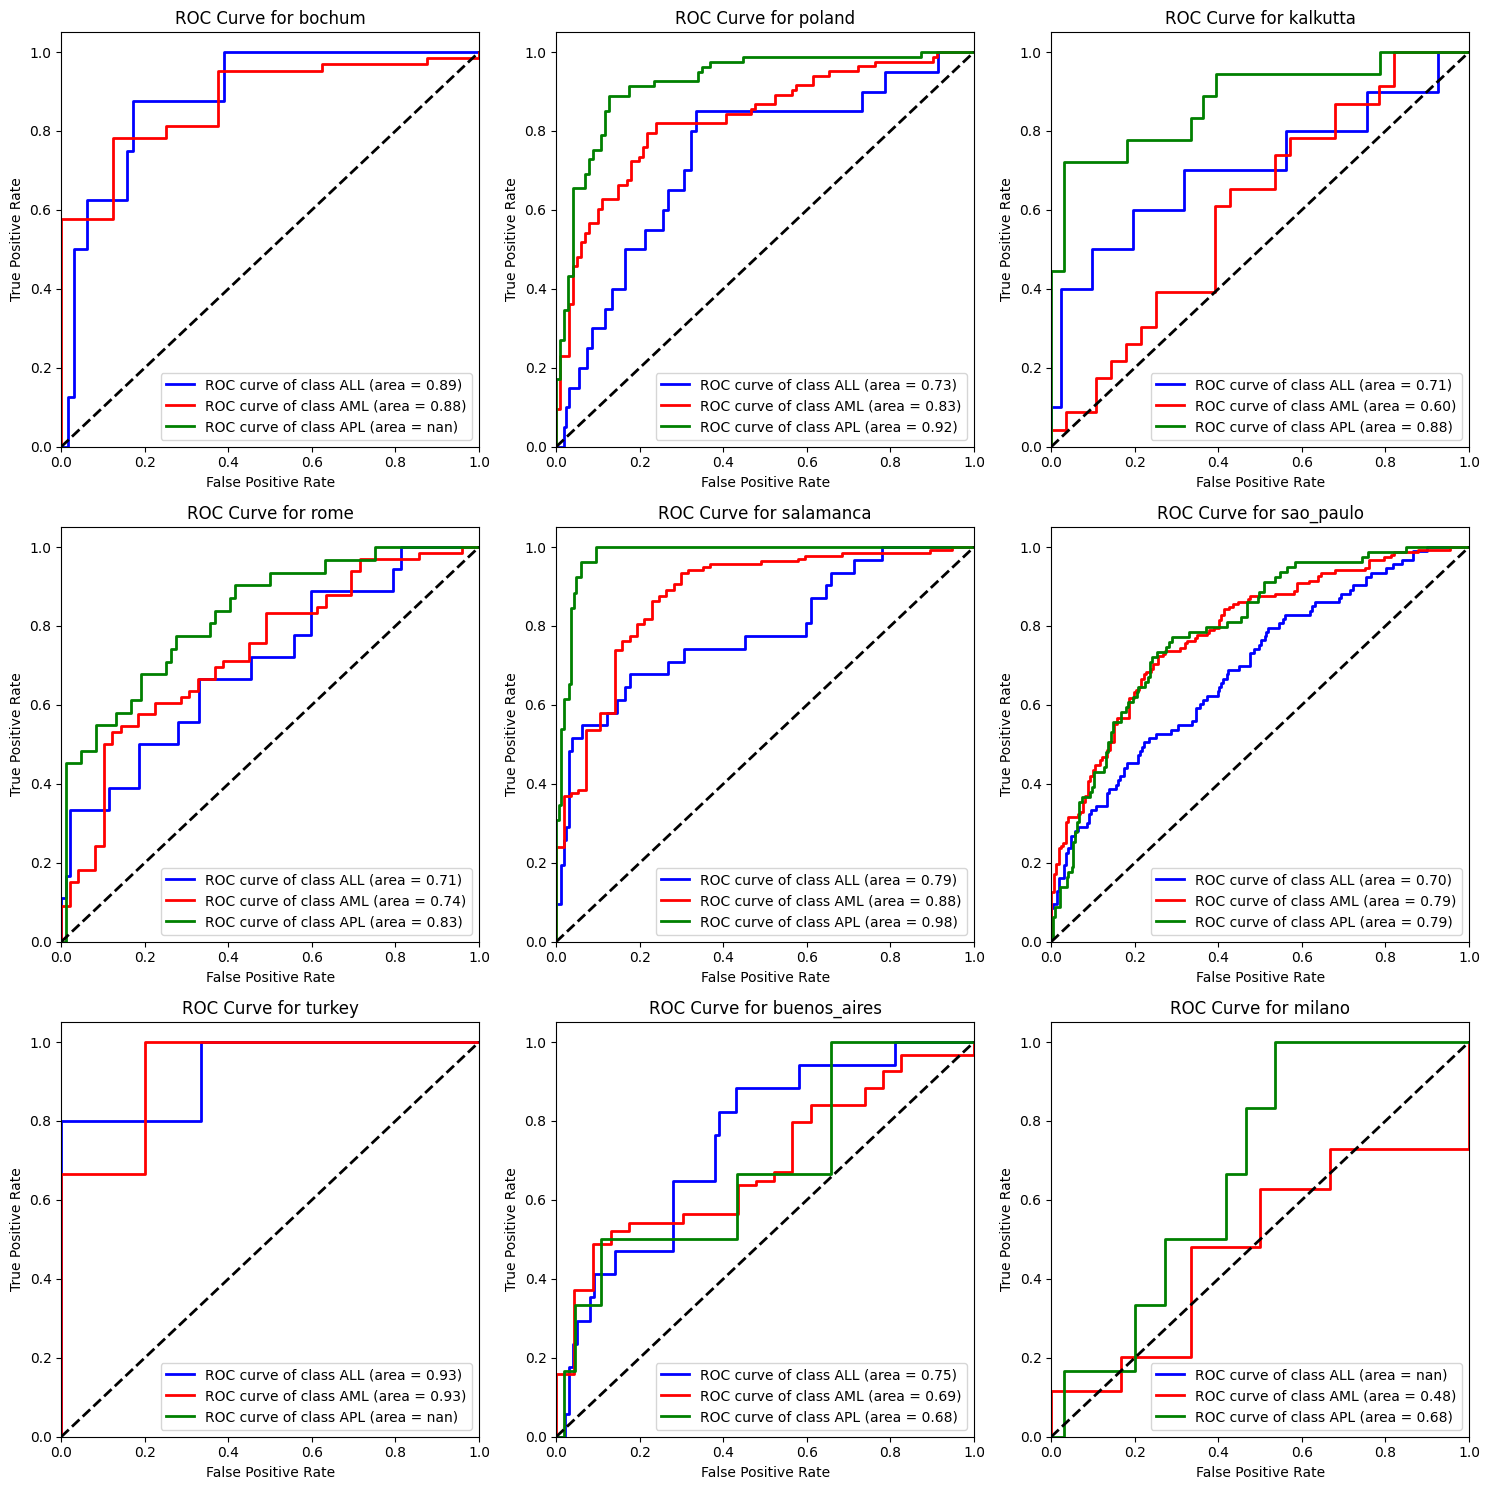

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

import matplotlib.pyplot as plt

# Create the figure with subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, city_country in enumerate(df['city_country'].unique()):
    df_small = df[df['city_country'] == city_country].copy()
    df_small[["prediction.ALL", "prediction.AML", "prediction.APL"]] = df_small[["prediction.ALL", "prediction.AML", "prediction.APL"]].astype(float)

    # Binarize the class labels
    classes = ["ALL", "AML", "APL"]
    y = label_binarize(df_small['class'], classes=classes)
    n_classes = y.shape[1]

    # Convert predictions to a similar format for ROC calculation
    y_score = df_small[["prediction.ALL", "prediction.AML", "prediction.APL"]].values

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Plot all ROC curves
    ax = axes[i]
    colors = ['blue', 'red', 'green']
    for j, color in zip(range(n_classes), colors):
        ax.plot(fpr[j], tpr[j], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes[j], roc_auc[j]))

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {city_country}')
    ax.legend(loc="lower right")

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()